# Chapter 13

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [ ]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [1]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/main/modsim.py')

In [ ]:
# import functions from modsim

from modsim import *

In [4]:
# import code from previous notebooks

from chap11 import make_system
from chap11 import update_func
from chap11 import run_simulation
from chap12 import calc_total_infected

In the previous chapters I presented an SIR model of infectious disease, specifically the Kermack-McKendrick model. We extended the model to include vaccination and the effect of a hand-washing campaign, and used the extended model to allocate a limited budget optimally, that is, to minimize the number of infections.

But we assumed that the parameters of the model, contact rate and
recovery rate, were known. In this chapter, we explore the behavior of
the model as we vary these parameters, use analysis to understand these relationships better, and propose a method for using data to estimate parameters.

## Sweeping beta

Recall that $\beta$ is the contact rate, which captures both the
frequency of interaction between people and the fraction of those
interactions that result in a new infection. If $N$ is the size of the
population and $s$ is the fraction that's susceptible, $s N$ is the
number of susceptibles, $\beta s N$ is the number of contacts per day
between susceptibles and other people, and $\beta s i N$ is the number
of those contacts where the other person is infectious.

As $\beta$ increases, we expect the total number of infections to
increase. To quantify that relationship, I'll create a range of values
for $\beta$:

In [5]:
beta_array = linspace(0.1, 1.1, 11)
gamma = 0.25

Then run the simulation for each value and print the results.

In [6]:
for beta in beta_array:
    system = make_system(beta, gamma)
    results = run_simulation(system, update_func)
    print(beta, calc_total_infected(results, system))

0.1 0.0072309016649785285
0.2 0.038410532615067994
0.30000000000000004 0.33703425948982
0.4 0.6502429153895082
0.5 0.8045061124629623
0.6 0.8862866308018508
0.7000000000000001 0.9316695082755875
0.8 0.9574278300784942
0.9 0.9720993156325133
1.0 0.9803437149675784
1.1 0.9848347293510136


We can wrap that code in a function and store the results in a
`SweepSeries` object:

In [7]:
def sweep_beta(beta_array, gamma):
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, update_func)
        sweep[beta] = calc_total_infected(results, system)
    return sweep

Now we can run `sweep_beta` like this:

In [8]:
infected_sweep = sweep_beta(beta_array, gamma)

And plot the results:

In [9]:
label = f'gamma = {gamma}'
label

'gamma = 0.25'

The first line uses a formatted string literal, also called an **f-string** to assemble a label for the plotted line:

-   An f-string starts with the letter "f" followed by a string in single or double quote. 

-   The string can contain any number of format specifiers in squiggly brackets, `{}`.

-   When a variable name appears in a format specifier, it is replaced with the value of the variable.

In this example, if the value of `gamma` is `0.25`, the value of `label` is `'gamma = 0.25'`.

You can read more about f-strings at <https://docs.python.org/3/tutorial/inputoutput.html#tut-f-strings>.



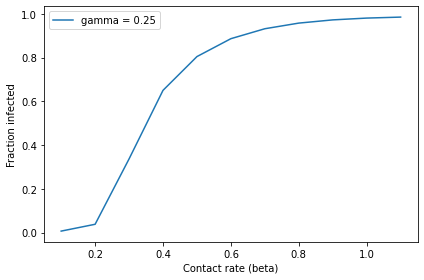

In [10]:
infected_sweep.plot(label=label)

decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected')

Remember that this figure
is a parameter sweep, not a time series, so the x-axis is the parameter
`beta`, not time.

When `beta` is small, the contact rate is low and the outbreak never
really takes off; the total number of infected students is near zero. As
`beta` increases, it reaches a threshold near 0.3 where the fraction of
infected students increases quickly. When `beta` exceeds 0.5, more than
80% of the population gets sick.

## Sweeping gamma

Let's see what that looks like for a few different values of `gamma`.
Again, we'll use `linspace` to make an array of values:

In [13]:
gamma_array = linspace(0.1, 0.7, 4)

And run `sweep_beta` for each value of `gamma`:

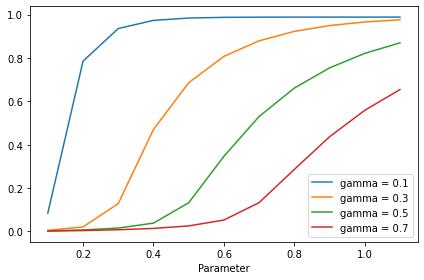

In [14]:
for gamma in gamma_array:
    infected_sweep = sweep_beta(beta_array, gamma)
    label = 'gamma = ' + str(gamma)
    infected_sweep.plot(label=label)
    
decorate()

When `gamma` is low, the recovery rate is low, which means people are infectious longer.
In that case, even a low contact rate (`beta`) results in an epidemic.

When `gamma` is high, `beta` has to be even higher to get things going.

## SweepFrame

In the previous section, we swept a range of values for `gamma`, and for
each value, we swept a range of values for `beta`. This process is a
**two-dimensional sweep**.

If we want to store the results, rather than plot them, we can use a
`SweepFrame`, which is a kind of `DataFrame` where the rows sweep one
parameter, the columns sweep another parameter, and the values contain
metrics from a simulation.

This function shows how it works:

In [15]:
def sweep_parameters(beta_array, gamma_array):
    frame = SweepFrame(columns=gamma_array)
    for gamma in gamma_array:
        frame[gamma] = sweep_beta(beta_array, gamma)
    return frame

`sweep_parameters` takes as parameters an array of values for `beta` and
an array of values for `gamma`.

It creates a `SweepFrame` to store the results, with one column for each
value of `gamma` and one row for each value of `beta`.

Each time through the loop, we run `sweep_beta`. The result is a
`SweepSeries` object with one element for each value of `beta`. The
assignment inside the loop stores the `SweepSeries` as a new column in
the `SweepFrame`, corresponding to the current value of `gamma`.

At the end, the `SweepFrame` stores the fraction of students infected
for each pair of parameters, `beta` and `gamma`.

We can run `sweep_parameters` like this:

In [16]:
frame = sweep_parameters(beta_array, gamma_array)

With the results in a `SweepFrame`, we can plot each column like this:

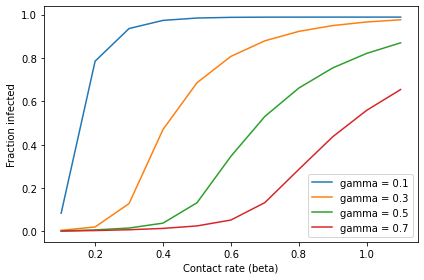

In [21]:
for gamma in gamma_array:
    label = f'gamma = {gamma}'
    frame[gamma].plot(label=label)

decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected')

Alternatively, we can plot each row like this:

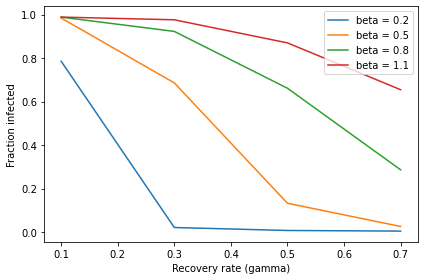

In [25]:
for beta in [0.2, 0.5, 0.8, 1.1]:
    label = f'beta = {beta}'
    frame.loc[beta].plot(label=label)
    
decorate(xlabel='Recovery rate (gamma)',
         ylabel='Fraction infected')

This example demonstrates one use of a `SweepFrame`: we can run the analysis once, save the results, and then generate different visualizations.

Another way to visualize the results of a two-dimensional sweep is a
**contour plot**, which shows the parameters on the axes and contour
lines, that is, lines of constant value. In this example, the value is
the fraction of students infected.

The ModSim library provides `contour`, which takes a `SweepFrame` as a
parameter:

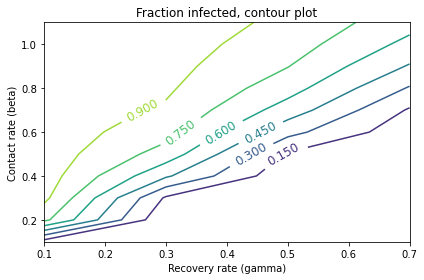

In [26]:
contour(frame)

decorate(xlabel='Recovery rate (gamma)',
         ylabel='Contact rate (beta)',
         title='Fraction infected, contour plot')

Infection rates are lowest in the lower right, where the contact rate is and the recovery rate is high. They increase as we move to the upper left, where the contact rate is high and the recovery rate is low.

This figure suggests that there might be a relationship between `beta`
and `gamma` that determines the outcome of the model. In fact, there is.
In the next chapter we'll explore it by running simulations, then derive it by analysis.



## Summary

## Exercises

**Exercise:**  Suppose the infectious period for the Freshman Plague is known to be 2 days on average, and suppose during one particularly bad year, 40% of the class is infected at some point.  Estimate the time between contacts.

In [32]:
# Solution

# Sweep beta with fixed gamma
gamma = 1/2
infected_sweep = sweep_beta(beta_array, gamma)
infected_sweep

Parameter
0.1    0.002736
0.2    0.007235
0.3    0.015929
0.4    0.038603
0.5    0.132438
0.6    0.346765
0.7    0.530585
0.8    0.661553
0.9    0.754595
1.0    0.821534
1.1    0.870219
Name: Metric, dtype: float64

In [30]:
# Solution

# Interpolating by eye, we can see that the infection rate passes 
# through 0.4 when beta is between 0.6 and 0.7
# We can use the `crossings` function to interpolate more precisely
# (although we don't know about it yet :)

beta_estimate = crossings(infected_sweep, 0.4)
beta_estimate

array([0.62548698])

In [31]:
# Solution

# Time between contacts is 1/beta

time_between_contacts = 1/beta_estimate
time_between_contacts

array([1.59875429])